Find all the chips in a FOV at different declinations to see whether the chipRADec-XY conversion is ok.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import time
import pandas as pd
import copy
import lsst.sims.maf.slicers as slicers
import healpy as hp
import lsst.sims.maf.metricBundles as metricBundles
repoDir= os.getcwd()
os.chdir(os.path.join(repoDir , '..' ))
repoDir= os.getcwd()
from intermediates import *
from plotFunctions import *
from astropy import units as u
from astropy.coordinates import SkyCoord, Galactic
from lsst.obs.lsstSim import LsstSimMapper
from lsst.sims.utils import ObservationMetaData
from lsst.sims.coordUtils import chipNameFromRaDec

In [2]:
path= '/Volumes/Transcend/'
path2= '2017-01-11/coaddM5Analysis_nside256_withDustExtinction_14pixelRadiusForMasking_rBand_minion1016_fullSurveyPeriod_directory/'
path3= 'maskedCoaddData/'
os.chdir(path+path2+path3)

# get the saved files
filenames = ['coaddM5Data_masked_r_NoDither.npz', 
             'coaddM5Data_masked_r_RandomDitherFieldPerVisit.npz']

coaddBundle= {}
for i in range(len(filenames)):
    mB = metricBundles.createEmptyMetricBundle()
    mB.read(filenames[i])
    dithStrategy= mB.metadata.strip()   # key is assigned to be the same as dithStrategy
    print 'Filename for ' + dithStrategy + ': ', filenames[i]
    print ''

    coaddBundle[dithStrategy]= mB

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Filename for NoDither:  coaddM5Data_masked_r_NoDither.npz

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Filename for RandomDitherFieldPerVisit:  coaddM5Data_masked_r_RandomDitherFieldPerVisit.npz



### Read in OpSim data.

In [3]:
dbpath = path+'minion_1016_sqlite_new_dithers.db'   # new afterburner output
extraCols= ['expDate', 'obsHistID','ditheredRotTelPos', 'rotTelPos']
simdata= getSimData(dbpath, 'r', extraCols= extraCols, newAfterburner= True)

In [4]:
# consider not just the unmasked one
def getSurveyHEALPixRADec(coaddBundle):
    """

    Modified from the one in the repo: want all the pixels; not the ones in the unmasked region of the survey.
    
    Get the RA, Dec (in radians) corresponding to each HEALPix pixel.
    Method returns a dictionary with keys= keys in coaddBundle: pixelNumber

    Required Parameter
    ------------------
    * coaddBundle: dict: dictionary with keys= observing strategy names, pointing to
                         corresponding to a metricBundle object.

    """
    # create dictionaries giving pixelNumbers and their correspondong RA, Dec for all dither strategies.
    # need to worry about each strategy separately since the mask is generally different.
    pixelNum= {}
    for dither in coaddBundle:
        pixelNum[dither]= []
        for pix in range(len(coaddBundle[dither].slicer)):
            #if not coaddBundle[dither].metricValues.mask[pix]:   # only consider the unmasked pixels
            pixelNum[dither].append(pix)

    return pixelNum

In [5]:
pixelNum= getSurveyHEALPixRADec(coaddBundle)   # each output is a dicitonary.

In [6]:
pixels_in_FOV= getFOVsHEALPixReln(pixelNum, simdata, nside= 256) # each output is a dicitonary.

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Number of fieldIDs in pixel_in_FOV for RandomDitherFieldPerVisit: 2293


In [7]:
ids, pointingRAs, pointingDecs, pointingbs= [], [], [], []
for fid in np.unique(simdata['fieldID']):
    #print fid
    ind= np.where(simdata['fieldID']==fid)[0]
    
    pointingRA= simdata['fieldRA'][ind][0]  #[index]  # poiting RA
    pointingDec= simdata['fieldDec'][ind[0]]    #[index]   # pointin Dec
    
    ids.append(fid)
    pointingRAs.append(pointingRA)
    pointingDecs.append(pointingDec)
    c= SkyCoord(ra= pointingRA*u.radian, dec= pointingDec*u.radian)

    pointingbs.append(c.transform_to(Galactic).b.radian)

In [8]:
pointingbs= np.array(pointingbs)
pointingRAs= np.array(pointingRAs)
pointingDecs= np.array(pointingDecs)
ids= np.array(ids)

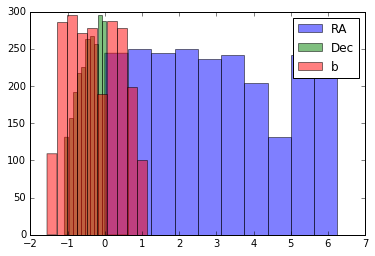

In [9]:
plt.hist(pointingRAs, alpha= 0.5, label= 'RA')
plt.hist(pointingDecs, alpha= 0.5, label= 'Dec')
plt.hist(pointingbs, alpha= 0.5, label= 'b')
plt.legend()

In [10]:
listInd= []
index= np.where(abs(pointingDecs) == min(abs(pointingDecs)))[0]
listInd+=list(index)
print 'index ', index
print 'b ', pointingbs[index]
print 'ra ', np.degrees(pointingRAs[index])
print 'dec ', np.degrees(pointingDecs[index])
print 'id ', ids[index]

print ''
index= np.where(pointingDecs == min(pointingDecs))[0]
listInd+=list(index)
print 'index ', index
print 'b ', pointingbs[index]
print 'ra ', np.degrees(pointingRAs[index])
print 'dec ', np.degrees(pointingDecs[index])
print 'id ', ids[index]


print ''
index= np.where(pointingbs == min(pointingbs))[0]
listInd+=list(index)
print 'index ', index
print 'b ', pointingbs[index]
print 'ra ', np.degrees(pointingRAs[index])
print 'dec ', np.degrees(pointingDecs[index])
print 'id ', ids[index]

listInd= np.array(listInd)

index  [2164 2165 2166 2167 2168 2169 2170 2171 2172 2173 2174]
b  [-0.60441539 -0.94397579  0.4486339   0.05376234 -0.65015374 -0.97770764
  0.97770802  0.65015346 -0.4486342   0.94397621  0.60441593]
ra  [ 322.4171596    37.5828228   253.58281224  106.41722746  325.58286601
   34.41717368  214.41713624  145.58284616   73.58279239  217.58278535
  142.41719705]
dec  [-0.1873572 -0.1873572 -0.1873572 -0.1873572 -0.1873572 -0.1873572
  0.1873572  0.1873572  0.1873572  0.1873572  0.1873572]
id  [2641 2642 2643 2644 2645 2646 2647 2648 2650 2651 2652]

index  [0 1]
b  [-0.11925987 -0.28381557]
ra  [ 240.05533599  119.94464641]
dec  [-62.02119163 -62.02119163]
id  [309 310]

index  [984]
b  [-1.55110164]
ra  [ 12.77529725]
dec  [-28.25421046]
id  [1397]


In [11]:
#idsToConsider= [2644, 310, 1397]
idsToConsider= ids[listInd]

In [12]:
#print idsToConsider

In [13]:
nside= 256

In [14]:
print listInd
print idsToConsider

[2164 2165 2166 2167 2168 2169 2170 2171 2172 2173 2174    0    1  984]
[2641 2642 2643 2644 2645 2646 2647 2648 2650 2651 2652  309  310 1397]


In [15]:
hpSlicer= slicers.HealpixSlicer(nside= nside)
hpSlicer.setupSlicer(simdata)    # slice data: know which pixels are observed in which visit
camera = LsstSimMapper().camera
diths= ['NoDither', 'RandomDitherFieldPerVisit']
chipNamesUniqList, obsIDsUniqList, expDatesUniqList, fIDsUniqList= {}, {}, {}, {}

startTime0= time.time()
for dither in diths:
    print '##', dither
    chipNamesUniqList[dither], obsIDsUniqList[dither], expDatesUniqList[dither], fIDsUniqList[dither]= {}, {}, {}, {}
    for ID in idsToConsider:
        print '#ID ', ID
        #print chipNames[ID], obsIDs[ID], expDates[ID], fIDs[ID]
        chipNames, obsIDs, expDates, fIDs= [], [], [], []
        chipNamesUniqList[dither][ID], obsIDsUniqList[dither][ID], expDatesUniqList[dither][ID], fIDsUniqList[dither][ID]= [], [], [], []

        prevPercent= 0.
        startTime= time.time()
        totPixels= len(pixels_in_FOV[dither][ID])
        for p, pixel in enumerate(pixels_in_FOV[dither][ID]):  # run over all the pixels in the region
            pixRA, pixDec= hpSlicer._pix2radec(pixel)    # radians returned
            indObsInPixel = hpSlicer._sliceSimData(pixel)   # indices in simData for when an observation
                                                            # happened in this pixel      
            for index in indObsInPixel['idxs']:
                # get data from simdata
                # for identifying each visit
                
                expDate= simdata[index]['expDate']
                obsID= simdata[index]['obsHistID']
                fID= simdata[index]['fieldID']
                expMJD= simdata[index]['expMJD']
                if (dither=='NoDither'):
                    pointingRA= simdata[index]['fieldRA'] # radians
                    pointingDec= simdata[index]['fieldDec'] # radians
                    rotSkyPos= simdata[index]['rotSkyPos'] # radians
                    
                else:   # random translational dithers
                    pointingRA= simdata[index]['randomDitherFieldPerVisitRA'] # radians
                    pointingDec= simdata[index]['randomDitherFieldPerVisitDec'] # radians
                    rotSkyPos= simdata[index]['rotSkyPos'] # radians
                
                # set up for the finding the chips
                obs = ObservationMetaData(pointingRA= np.degrees(pointingRA), pointingDec= np.degrees(pointingDec),
                                          rotSkyPos= np.degrees(rotSkyPos), mjd= expMJD)
                chipsInVisit= chipNameFromRaDec(np.degrees(pixRA), np.degrees(pixDec),
                                                camera=camera, obs_metadata=obs)
                if chipsInVisit is not None:   # not 100% clear why some pixels don't have any chips.
                    obsIDs.append(obsID)
                    expDates.append(expDate)
                    chipNames.append(chipsInVisit)
                    fIDs.append(fID)

            percentDone= 100.*(p+1)/totPixels
            delPercent= percentDone-prevPercent
            if (delPercent>5):
                print '%f%% pixels done\nTime passed (min): %f'%(percentDone, (time.time()-startTime)/60.)
                prevPercent= percentDone
        obsIDs, expDates, fIDs, chipNames= np.array(obsIDs), np.array(expDates), np.array(fIDs), np.array(chipNames)

        for obs in np.unique(obsIDs):
            obsIDsUniqList[dither][ID].append(obs)
            ind= np.where(obsIDs==obs)[0]
            expDatesUniqList[dither][ID].append(np.unique(expDates[ind]))
            fIDsUniqList[dither][ID].append(np.unique(fIDs[ind]))
            chipNamesUniqList[dither][ID].append(np.unique(chipNames[ind]))
            
        print ''
    print '\nTime passed for this dither (min): %f'%((time.time()-startTime0)/60.)
print '\nTime passed (min): %f'%((time.time()-startTime0)/60.)

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
## NoDither
#ID  2641


/Users/Humna/lsst/DarwinX86/sims_utils/12.0-13-g6534730/python/lsst/sims/utils/ModifiedJulianDate.py:188: UTCtoUT1Warning: UTC is outside of IERS table for UT1-UTC.
Returning UT1 = UTC for lack of a better idea
This warning was caused by calling ModifiedJulianDate.dut1

  category=UTCtoUT1Warning)


5.524862% pixels done
Time passed (min): 0.808220
11.049724% pixels done
Time passed (min): 1.509698
16.574586% pixels done
Time passed (min): 2.197581
22.099448% pixels done
Time passed (min): 2.777413
27.624309% pixels done
Time passed (min): 3.222113
33.149171% pixels done
Time passed (min): 3.662043
38.674033% pixels done
Time passed (min): 4.108641
44.198895% pixels done
Time passed (min): 4.546282
49.723757% pixels done
Time passed (min): 5.023338
55.248619% pixels done
Time passed (min): 5.510860
60.773481% pixels done
Time passed (min): 6.002767
66.298343% pixels done
Time passed (min): 6.486643
71.823204% pixels done
Time passed (min): 6.939312
77.348066% pixels done
Time passed (min): 7.357365
82.872928% pixels done
Time passed (min): 8.065692
88.397790% pixels done
Time passed (min): 8.781645
93.922652% pixels done
Time passed (min): 9.340797
99.447514% pixels done
Time passed (min): 10.061173

#ID  2642
5.524862% pixels done
Time passed (min): 0.679386
11.049724% pixels don

/Users/Humna/lsst/DarwinX86/sims_coordUtils/12.0-4-g7de6cfa+29/python/lsst/sims/coordUtils/CameraUtils.py:325: MultipleChipWarning: An object has landed on multiple chips.  You asked for this not to happen.
We will return only one of the chip names.  If you want both, try re-running with the kwarg allow_multiple_chips=True.
Offending chip names were ['R:4,0 S:0,2,A', 'R:4,0 S:0,2,B']
Offending pupil coordinate point was 0.021139134342 -0.020520711362

  category=MultipleChipWarning)


38.674033% pixels done
Time passed (min): 3.823890


/Users/Humna/lsst/DarwinX86/sims_coordUtils/12.0-4-g7de6cfa+29/python/lsst/sims/coordUtils/CameraUtils.py:325: MultipleChipWarning: An object has landed on multiple chips.  You asked for this not to happen.
We will return only one of the chip names.  If you want both, try re-running with the kwarg allow_multiple_chips=True.
Offending chip names were ['R:4,0 S:0,2,A', 'R:4,0 S:0,2,B']
Offending pupil coordinate point was 0.019667115550 -0.020521140520

  category=MultipleChipWarning)


44.198895% pixels done
Time passed (min): 4.256829
49.723757% pixels done
Time passed (min): 4.736336
55.248619% pixels done
Time passed (min): 5.247248
60.773481% pixels done
Time passed (min): 5.732883
66.298343% pixels done
Time passed (min): 6.286707
71.823204% pixels done
Time passed (min): 6.783837
77.348066% pixels done
Time passed (min): 7.231962
82.872928% pixels done
Time passed (min): 7.737753
88.397790% pixels done
Time passed (min): 8.376900
93.922652% pixels done
Time passed (min): 8.962405
99.447514% pixels done
Time passed (min): 9.694256

#ID  2643
5.405405% pixels done
Time passed (min): 0.704950
10.810811% pixels done
Time passed (min): 1.445992
16.216216% pixels done
Time passed (min): 2.245835


/Users/Humna/lsst/DarwinX86/sims_coordUtils/12.0-4-g7de6cfa+29/python/lsst/sims/coordUtils/CameraUtils.py:325: MultipleChipWarning: An object has landed on multiple chips.  You asked for this not to happen.
We will return only one of the chip names.  If you want both, try re-running with the kwarg allow_multiple_chips=True.
Offending chip names were ['R:4,0 S:0,2,A', 'R:4,0 S:0,2,B']
Offending pupil coordinate point was 0.022455840359 -0.020520848575

  category=MultipleChipWarning)


21.621622% pixels done
Time passed (min): 2.929620
27.027027% pixels done
Time passed (min): 3.547961
32.432432% pixels done
Time passed (min): 3.921147
37.837838% pixels done
Time passed (min): 4.299683
43.243243% pixels done
Time passed (min): 4.772199
48.648649% pixels done
Time passed (min): 5.220086
54.054054% pixels done
Time passed (min): 5.706672
59.459459% pixels done
Time passed (min): 6.150211
64.864865% pixels done
Time passed (min): 6.606418
70.270270% pixels done
Time passed (min): 7.085907
75.675676% pixels done
Time passed (min): 7.530500
81.081081% pixels done
Time passed (min): 8.007561
86.486486% pixels done
Time passed (min): 8.670980
91.891892% pixels done
Time passed (min): 9.411995
97.297297% pixels done
Time passed (min): 10.233161

#ID  2644
5.405405% pixels done
Time passed (min): 0.782843
10.810811% pixels done
Time passed (min): 1.445935
16.216216% pixels done
Time passed (min): 2.109019
21.621622% pixels done
Time passed (min): 2.686755
27.027027% pixels do

/Users/Humna/lsst/DarwinX86/sims_coordUtils/12.0-4-g7de6cfa+29/python/lsst/sims/coordUtils/CameraUtils.py:325: MultipleChipWarning: An object has landed on multiple chips.  You asked for this not to happen.
We will return only one of the chip names.  If you want both, try re-running with the kwarg allow_multiple_chips=True.
Offending chip names were ['R:4,0 S:0,2,A', 'R:4,0 S:0,2,B']
Offending pupil coordinate point was 0.021964680049 -0.020519875900

  category=MultipleChipWarning)


54.945055% pixels done
Time passed (min): 4.996390
60.439560% pixels done
Time passed (min): 5.469564
65.934066% pixels done
Time passed (min): 6.021233
71.428571% pixels done
Time passed (min): 6.462640
76.923077% pixels done
Time passed (min): 6.832262
82.417582% pixels done
Time passed (min): 7.307481
87.912088% pixels done
Time passed (min): 7.851032
93.406593% pixels done
Time passed (min): 8.392515
98.901099% pixels done
Time passed (min): 9.037126

#ID  2646
5.494505% pixels done
Time passed (min): 0.685457
10.989011% pixels done
Time passed (min): 1.339492
16.483516% pixels done
Time passed (min): 2.014545


/Users/Humna/lsst/DarwinX86/sims_coordUtils/12.0-4-g7de6cfa+29/python/lsst/sims/coordUtils/CameraUtils.py:325: MultipleChipWarning: An object has landed on multiple chips.  You asked for this not to happen.
We will return only one of the chip names.  If you want both, try re-running with the kwarg allow_multiple_chips=True.
Offending chip names were ['R:0,4 S:2,0,A', 'R:0,4 S:2,0,B']
Offending pupil coordinate point was -0.020654243433 0.020511161580

  category=MultipleChipWarning)


21.978022% pixels done
Time passed (min): 2.708306
27.472527% pixels done
Time passed (min): 3.129622
32.967033% pixels done
Time passed (min): 3.582562
38.461538% pixels done
Time passed (min): 3.989276
43.956044% pixels done
Time passed (min): 4.432764
49.450549% pixels done
Time passed (min): 4.863610
54.945055% pixels done
Time passed (min): 5.278544
60.439560% pixels done
Time passed (min): 5.752963
65.934066% pixels done
Time passed (min): 6.173559
71.428571% pixels done
Time passed (min): 6.547928
76.923077% pixels done
Time passed (min): 6.982423
82.417582% pixels done
Time passed (min): 7.400338
87.912088% pixels done
Time passed (min): 7.952574
93.406593% pixels done
Time passed (min): 8.580732
98.901099% pixels done
Time passed (min): 9.257646

#ID  2647
5.494505% pixels done
Time passed (min): 0.661878


/Users/Humna/lsst/DarwinX86/sims_coordUtils/12.0-4-g7de6cfa+29/python/lsst/sims/coordUtils/CameraUtils.py:325: MultipleChipWarning: An object has landed on multiple chips.  You asked for this not to happen.
We will return only one of the chip names.  If you want both, try re-running with the kwarg allow_multiple_chips=True.
Offending chip names were ['R:0,4 S:2,0,A', 'R:0,4 S:2,0,B']
Offending pupil coordinate point was -0.019938400882 0.020512119669

  category=MultipleChipWarning)


10.989011% pixels done
Time passed (min): 1.218077
16.483516% pixels done
Time passed (min): 1.805733
21.978022% pixels done
Time passed (min): 2.384561
27.472527% pixels done
Time passed (min): 2.898719
32.967033% pixels done
Time passed (min): 3.363138
38.461538% pixels done
Time passed (min): 3.906964
43.956044% pixels done
Time passed (min): 4.465657
49.450549% pixels done
Time passed (min): 4.979279
54.945055% pixels done
Time passed (min): 5.548191
60.439560% pixels done
Time passed (min): 6.131926
65.934066% pixels done
Time passed (min): 6.530994
71.428571% pixels done
Time passed (min): 6.910204
76.923077% pixels done
Time passed (min): 7.323111
82.417582% pixels done
Time passed (min): 7.772635
87.912088% pixels done
Time passed (min): 8.407252
93.406593% pixels done
Time passed (min): 9.086114
98.901099% pixels done
Time passed (min): 9.745511

#ID  2648
5.494505% pixels done
Time passed (min): 0.728502
10.989011% pixels done
Time passed (min): 1.350651
16.483516% pixels don

/Users/Humna/lsst/DarwinX86/sims_coordUtils/12.0-4-g7de6cfa+29/python/lsst/sims/coordUtils/CameraUtils.py:325: MultipleChipWarning: An object has landed on multiple chips.  You asked for this not to happen.
We will return only one of the chip names.  If you want both, try re-running with the kwarg allow_multiple_chips=True.
Offending chip names were ['R:4,0 S:0,2,A', 'R:4,0 S:0,2,B']
Offending pupil coordinate point was 0.019378254724 -0.020523155405

  category=MultipleChipWarning)


22.099448% pixels done
Time passed (min): 2.550203
27.624309% pixels done
Time passed (min): 3.048772
33.149171% pixels done
Time passed (min): 3.552581
38.674033% pixels done
Time passed (min): 4.016489
44.198895% pixels done
Time passed (min): 4.428655
49.723757% pixels done
Time passed (min): 4.843973
55.248619% pixels done
Time passed (min): 5.261321
60.773481% pixels done
Time passed (min): 5.643382
66.298343% pixels done
Time passed (min): 6.062804
71.823204% pixels done
Time passed (min): 6.447830
77.348066% pixels done
Time passed (min): 6.832001
82.872928% pixels done
Time passed (min): 7.324791
88.397790% pixels done
Time passed (min): 7.889634
93.922652% pixels done
Time passed (min): 8.735316
99.447514% pixels done
Time passed (min): 9.478418

#ID  309
5.555556% pixels done
Time passed (min): 0.395806
11.111111% pixels done
Time passed (min): 0.822603
16.666667% pixels done
Time passed (min): 1.246239
22.222222% pixels done
Time passed (min): 1.692356
27.777778% pixels done

In [16]:
startTime1= time.time()
for dither in ['RandomDitherFieldPerVisit_rotDithers']:   # rot dithers
    print '##', dither
    chipNamesUniqList[dither], obsIDsUniqList[dither], expDatesUniqList[dither], fIDsUniqList[dither]= {}, {}, {}, {}
    for ID in idsToConsider:
        print '#ID ', ID
        chipNames, obsIDs, expDates, fIDs= [], [], [], []
        chipNamesUniqList[dither][ID], obsIDsUniqList[dither][ID], expDatesUniqList[dither][ID], fIDsUniqList[dither][ID]= [], [], [], []

        prevPercent= 0.
        startTime= time.time()
        totPixels= len(pixels_in_FOV['RandomDitherFieldPerVisit'][ID])
        for p, pixel in enumerate(pixels_in_FOV['RandomDitherFieldPerVisit'][ID]):  # run over all the pixels in the region
            pixRA, pixDec= hpSlicer._pix2radec(pixel)    # radians returned
            indObsInPixel = hpSlicer._sliceSimData(pixel)   # indices in simData for when an observation
                                                            # happened in this pixel      
            for index in indObsInPixel['idxs']:
                # get data from simdata
                # for identifying each visit
                
                expDate= simdata[index]['expDate']
                obsID= simdata[index]['obsHistID']
                fID= simdata[index]['fieldID']
                expMJD= simdata[index]['expMJD']
                pointingRA= simdata[index]['randomDitherFieldPerVisitRA'] # radians
                pointingDec= simdata[index]['randomDitherFieldPerVisitDec'] # radians
                rotSkyPos= simdata[index]['rotSkyPos'] # radians
                parallacticAngle= simdata[index]['rotTelPos']-simdata[index]['rotSkyPos']
                ditheredRotSkyPos= simdata[index]['ditheredRotTelPos']-parallacticAngle
                rotSkyPos= ditheredRotSkyPos
                
                # set up for the finding the chips
                obs = ObservationMetaData(pointingRA= np.degrees(pointingRA), pointingDec= np.degrees(pointingDec),
                                          rotSkyPos= np.degrees(rotSkyPos), mjd= expMJD)
                chipsInVisit= chipNameFromRaDec(np.degrees(pixRA), np.degrees(pixDec),
                                                camera=camera, obs_metadata=obs)
                if chipsInVisit is not None:   # not 100% clear why some pixels don't have any chips.
                    obsIDs.append(obsID)
                    expDates.append(expDate)
                    chipNames.append(chipsInVisit)
                    fIDs.append(fID)

            percentDone= 100.*(p+1)/totPixels
            delPercent= percentDone-prevPercent
            if (delPercent>5):
                print '%f%% pixels done\nTime passed (min): %f'%(percentDone, (time.time()-startTime)/60.)
                prevPercent= percentDone
        obsIDs, expDates, fIDs, chipNames= np.array(obsIDs), np.array(expDates), np.array(fIDs), np.array(chipNames)

        for obs in np.unique(obsIDs):
            obsIDsUniqList[dither][ID].append(obs)
            ind= np.where(obsIDs==obs)[0]
            expDatesUniqList[dither][ID].append(np.unique(expDates[ind]))
            fIDsUniqList[dither][ID].append(np.unique(fIDs[ind]))
            chipNamesUniqList[dither][ID].append(np.unique(chipNames[ind]))
            
        print ''
    
print '\nTime passed (min): %f'%((time.time()-startTime1)/60.)

## RandomDitherFieldPerVisit_rotDithers
#ID  2641
5.524862% pixels done
Time passed (min): 0.662727
11.049724% pixels done
Time passed (min): 1.263542
16.574586% pixels done
Time passed (min): 1.857990
22.099448% pixels done
Time passed (min): 2.340590
27.624309% pixels done
Time passed (min): 2.708312
33.149171% pixels done
Time passed (min): 3.074881
38.674033% pixels done
Time passed (min): 3.453777
44.198895% pixels done
Time passed (min): 3.833062
49.723757% pixels done
Time passed (min): 4.237067
55.248619% pixels done
Time passed (min): 4.652216
60.773481% pixels done
Time passed (min): 5.055930
66.298343% pixels done
Time passed (min): 5.466508
71.823204% pixels done
Time passed (min): 5.864552
77.348066% pixels done
Time passed (min): 6.220011
82.872928% pixels done
Time passed (min): 6.705010
88.397790% pixels done
Time passed (min): 7.259031
93.922652% pixels done
Time passed (min): 7.776907
99.447514% pixels done
Time passed (min): 8.434108

#ID  2642
5.524862% pixels done


/Users/Humna/lsst/DarwinX86/sims_coordUtils/12.0-4-g7de6cfa+29/python/lsst/sims/coordUtils/CameraUtils.py:325: MultipleChipWarning: An object has landed on multiple chips.  You asked for this not to happen.
We will return only one of the chip names.  If you want both, try re-running with the kwarg allow_multiple_chips=True.
Offending chip names were ['R:4,0 S:0,2,A', 'R:4,0 S:0,2,B']
Offending pupil coordinate point was 0.020478886739 -0.020520975976

  category=MultipleChipWarning)


100.000000% pixels done
Time passed (min): 7.395212

#ID  1397
5.464481% pixels done
Time passed (min): 0.666326
10.928962% pixels done
Time passed (min): 1.237409
16.393443% pixels done
Time passed (min): 1.621270
21.857923% pixels done
Time passed (min): 2.014796
27.322404% pixels done
Time passed (min): 2.494893
32.786885% pixels done
Time passed (min): 2.979782
38.251366% pixels done
Time passed (min): 3.470918
43.715847% pixels done
Time passed (min): 3.960065
49.180328% pixels done
Time passed (min): 4.448813
54.644809% pixels done
Time passed (min): 4.890207
60.109290% pixels done
Time passed (min): 5.376302
65.573770% pixels done
Time passed (min): 5.814214
71.038251% pixels done
Time passed (min): 6.251758
76.502732% pixels done
Time passed (min): 6.695775
81.967213% pixels done
Time passed (min): 7.110352
87.431694% pixels done
Time passed (min): 7.495376
92.896175% pixels done
Time passed (min): 8.017373
98.360656% pixels done
Time passed (min): 8.645887


Time passed (min):

310
** All chips (including wavefront) **
-- Max number of chips added by any given visit: 162
-- Min number of chips added by any given visit: 1
-- Total number of chips (across all visits to be simulated): 35737
1397
** All chips (including wavefront) **
-- Max number of chips added by any given visit: 177
-- Min number of chips added by any given visit: 3
-- Total number of chips (across all visits to be simulated): 43670
2641
** All chips (including wavefront) **
-- Max number of chips added by any given visit: 177
-- Min number of chips added by any given visit: 2
-- Total number of chips (across all visits to be simulated): 43181
2642
** All chips (including wavefront) **
-- Max number of chips added by any given visit: 176
-- Min number of chips added by any given visit: 2
-- Total number of chips (across all visits to be simulated): 43278
2643
** All chips (including wavefront) **
-- Max number of chips added by any given visit: 176
-- Min number of chips added by any given vis

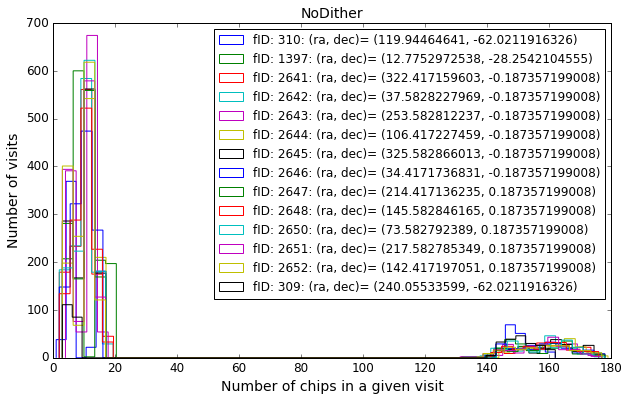

310
** All chips (including wavefront) **
-- Max number of chips added by any given visit: 155
-- Min number of chips added by any given visit: 1
-- Total number of chips (across all visits to be simulated): 23689
1397
** All chips (including wavefront) **
-- Max number of chips added by any given visit: 168
-- Min number of chips added by any given visit: 1
-- Total number of chips (across all visits to be simulated): 27168
2641
** All chips (including wavefront) **
-- Max number of chips added by any given visit: 162
-- Min number of chips added by any given visit: 1
-- Total number of chips (across all visits to be simulated): 26872
2642
** All chips (including wavefront) **
-- Max number of chips added by any given visit: 167
-- Min number of chips added by any given visit: 1
-- Total number of chips (across all visits to be simulated): 27047
2643
** All chips (including wavefront) **
-- Max number of chips added by any given visit: 172
-- Min number of chips added by any given vis

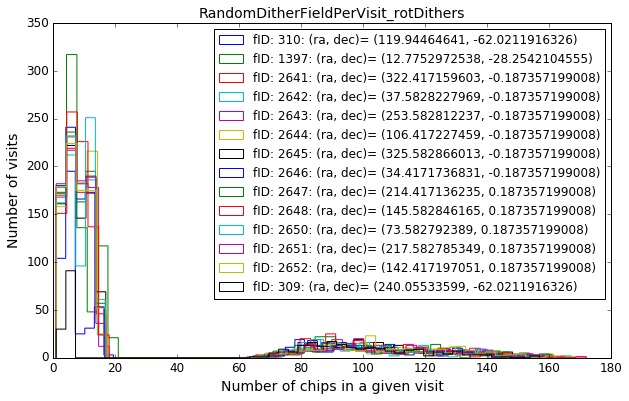

310
** All chips (including wavefront) **
-- Max number of chips added by any given visit: 159
-- Min number of chips added by any given visit: 1
-- Total number of chips (across all visits to be simulated): 23742
1397
** All chips (including wavefront) **
-- Max number of chips added by any given visit: 162
-- Min number of chips added by any given visit: 1
-- Total number of chips (across all visits to be simulated): 26930
2641
** All chips (including wavefront) **
-- Max number of chips added by any given visit: 164
-- Min number of chips added by any given visit: 1
-- Total number of chips (across all visits to be simulated): 26935
2642
** All chips (including wavefront) **
-- Max number of chips added by any given visit: 164
-- Min number of chips added by any given visit: 1
-- Total number of chips (across all visits to be simulated): 27274
2643
** All chips (including wavefront) **
-- Max number of chips added by any given visit: 156
-- Min number of chips added by any given vis

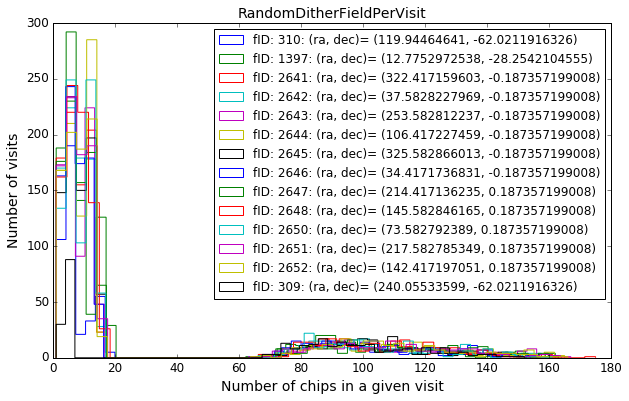

In [17]:
for dith in chipNamesUniqList:
    for ID in chipNamesUniqList['NoDither']:
        index= np.where(ids==ID)[0]
        ra= np.degrees(pointingRAs[index])[0]
        dec= np.degrees(pointingDecs[index])[0]
    
        numChipsAll= []
        numChipToSim= []
        print ID
        for i in range(len(obsIDsUniqList[dith][ID])):

            temp= chipNamesUniqList[dith][ID][i]

            numChipsAll.append(len(temp))
        print '** All chips (including wavefront) **'
        print '-- Max number of chips added by any given visit: %d'%(max(numChipsAll))
        print '-- Min number of chips added by any given visit: %d'%(min(numChipsAll))
        print '-- Total number of chips (across all visits to be simulated): %d'%(sum(numChipsAll))   

        bins= 50
        alpha= 1 #0.2
        fontsize= 14
        
        plt.hist(numChipsAll, histtype= 'step', label= 'fID: %s: (ra, dec)= (%s, %s)'%(ID, ra, dec), 
                                                                                       alpha= alpha, bins= bins)
    plt.title(dith, fontsize= fontsize)
    plt.legend()
    plt.xlabel('Number of chips in a given visit', fontsize= fontsize)
    plt.ylabel('Number of visits', fontsize= fontsize)
    plt.legend(loc= 1)#bbox_to_anchor= (1.5,0.5))
    plt.tick_params(axis='x', labelsize=fontsize-2)
    plt.tick_params(axis='y', labelsize=fontsize-2)
    fig = plt.gcf()
    fig.set_size_inches(10, 6)


    plt.show()

In [18]:
for ID in idsToConsider:
    print ID
    print len(pixels_in_FOV['NoDither'][ID])
    print ''

2641
181

2642
181

2643
185

2644
185

2645
182

2646
182

2647
182

2648
182

2650
185

2651
181

2652
181

309
180

310
180

1397
183



In [19]:
colors= ['r', 'g', 'b']

In [20]:
ras, decs, totNumChips= {}, {}, {}
for j, dith in enumerate(chipNamesUniqList):
    ras[dith], decs[dith], totNumChips[dith]= [], [], []
    for k, ID in enumerate(chipNamesUniqList['NoDither']):
        index= np.where(ids==ID)[0]
        ra= np.degrees(pointingRAs[index])[0]
        dec= np.degrees(pointingDecs[index])[0]
    
        numChipsAll= []
        for i in range(len(obsIDsUniqList[dith][ID])):
            temp= chipNamesUniqList[dith][ID][i]
            numChipsAll.append(len(temp))
        ras[dith].append(ra)
        decs[dith].append(dec)
        totNumChips[dith].append(sum(numChipsAll))
        
    ras[dith]= np.array(ras[dith])
    decs[dith]= np.array(decs[dith])
    totNumChips[dith]= np.array(totNumChips[dith])

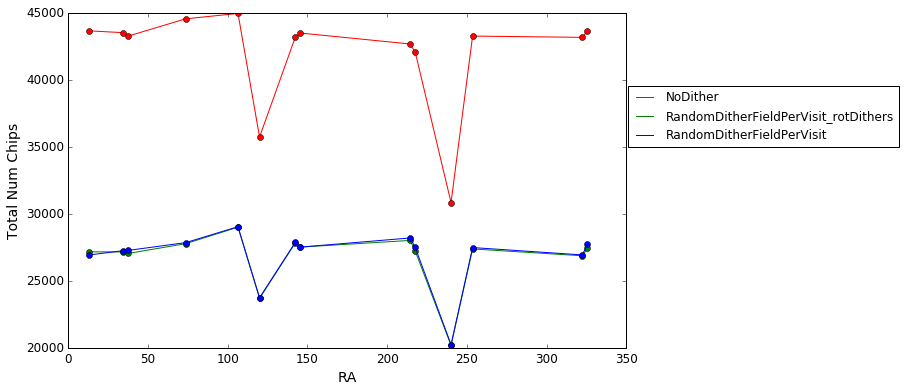

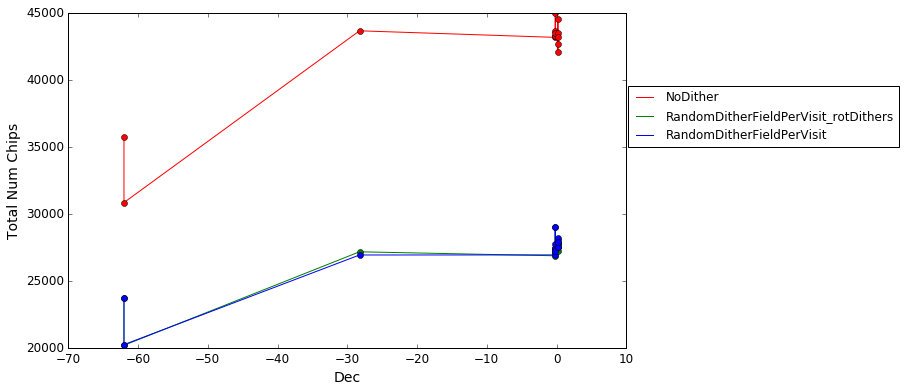

In [21]:
for i, dith in enumerate(ras):
    sortInd= np.argsort(ras[dith])
    plt.plot(ras[dith][sortInd], totNumChips[dith][sortInd], label= dith, color= colors[i])
    plt.plot(ras[dith][sortInd], totNumChips[dith][sortInd], 'o', color= colors[i])
plt.legend(bbox_to_anchor= (1.5, 0.8))
plt.xlabel('RA', fontsize= fontsize)
plt.ylabel('Total Num Chips', fontsize= fontsize)
plt.tick_params(axis='x', labelsize=fontsize-2)
plt.tick_params(axis='y', labelsize=fontsize-2)
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.show()

for i, dith in enumerate(ras):
    sortInd= np.argsort(decs[dith])
    plt.plot(decs[dith][sortInd], totNumChips[dith][sortInd], label= dith, color= colors[i])
    plt.plot(decs[dith][sortInd], totNumChips[dith][sortInd], 'o', color= colors[i])
plt.legend(bbox_to_anchor= (1.5, 0.8))
plt.xlabel('Dec', fontsize= fontsize)
plt.ylabel('Total Num Chips', fontsize= fontsize)
plt.tick_params(axis='x', labelsize=fontsize-2)
plt.tick_params(axis='y', labelsize=fontsize-2)
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.show()